In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

### Plotting utilities

In [25]:
def plotter(f):
  def plotter_function(*args, figsize=(12, 12), title='Big title', **kwargs):
    plt.figure(figsize=figsize, tight_layout=True)
    f(*args, **kwargs)
    figure = plt.gcf()
    figure.suptitle(title, fontsize=16, y=1.05)
  return plotter_function

In [48]:
@plotter
def plot_each_col(data, 
                  col_list, 
                  n_col, 
                  plot_type, 
                  x=None,
                  top=10,
                  title_suffix="Distribution of",
                  **kwargs):
  '''
  Plot a subplot of specified type on each selected column. 

  Arguments:
  data: Input DataFrame
  col_list: The columns to be plotted.
  n_col: Number of subplots on each row.
  plot_type: Graph type.
  x: The column for x-axis, used for graphs type like line and trend graph.
  top: For "top" plot_type. If positive, get the top most frequent values, else get the least frequent values.
  '''
  n_row = len(col_list) // n_col + 1
  for i, col in enumerate(col_list):
    ax = plt.subplot(n_row, n_col, i + 1)
    if plot_type == "hist":
      sns.histplot(data=data, x=col, multiple="stack", **kwargs)
    
    elif plot_type == "bar":
      sns.barplot(data=data, x=col, **kwargs)

    elif plot_type == "count":
      sns.countplot(data=data, x=col, **kwargs)

    elif plot_type == "box":
      sns.boxplot(data=data, x=col, **kwargs)
    
    elif plot_type == "line":
      if x:
        sns.lineplot(data=data, x=x, y=col, ax=ax, **kwargs)

      else:
        sns.lineplot(data=data, x=data.index, y=col, ax=ax, **kwargs)
    
    elif plot_type == "trend":
      plot_trend(data=data, x=x, y=col, ax=ax, **kwargs)

    elif plot_type == "top":
      temp = data[col].value_counts()
      if top > 0:
        sns.barplot(x=temp.index[0:top], y=temp[0:top])
      else:
        sns.barplot(x=temp.index[-1:top:-1], y=temp[-1:top:-1])

    else:
      raise ValueError(f"Invalid plot_type argument: {plot_type}")

    ax.set_title(f"{title_suffix} {col}")

def create_moving_average(data, average=7, min_periods=1):
  return data.rolling(average, min_periods=min_periods).mean()

def plot_trend(data, y, x=None, ax=None, 
               date_index=True, date_index_name=None, 
               moving_average=None, min_periods=1,
               label=None, ax_format=None, **kwargs):
  '''
  Plot a line graph on the trend on a new or existing ax object.

  Arguments:
  data: A pandas DataFrame. Do not pass a pandas Series
  y: Column name for plotting y-axis
  ax: If None, plot on a new ax object.
  date_index: If passed, the x-axis will be formatted nicely for a date_index
  date_index_name: The index level name holding the date values.
  moving_average: If integer is passed, will create a moving average on y-value.
  min_periods: min_periods for moving_average.
  label: Name for legend
  ax_format: Function that takes an ax for formatting.
  '''
  if date_index:
    if date_index_name is None:
      raise ValueError("Must pass in date_index_name")
    
    if x is not None:
      raise ValueError("Cannot pass x argument when setting date_index to True")
    
    x = data.index.get_level_values(date_index_name).map(lambda x: dt.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))

  if label is None:
    label = y

  if moving_average is not None:
    data = create_moving_average(data[[y]], average=moving_average, min_periods=min_periods)
  
  if ax is None:
    ax = sns.lineplot(data=data, x=x, y=y, label=label, **kwargs)

    if date_index:
      ax_format(ax)

  else:
    ax = sns.lineplot(data=data, x=x, y=y, ax=ax, label=label, **kwargs)

  return ax

def locate_outlier(df, columns, zscore_threshold, any=True, exclude=False):
  '''
  Locate outliers from numerical columns.
  Arguments:
  df: pandas DataFrame
  columns: A list of column's names for checking outliers. Must be numerical columns
  zscore_threshold: Threshold for classifying outliers.
  any: If True, classify the data point as outlier if value from one of the column is a outlier.
  exclude: If True, return non-outliers. If False, return outliers.

  Returns pandas DataFrame.
  '''
  mask_include = np.abs(stats.zscore(df[columns])) > zscore_threshold
  mask_exclude = np.abs(stats.zscore(df[columns])) < zscore_threshold

  if any:
    if exclude:
      return df[mask_exclude.any(axis=1)]
    else:
      df = df[mask_include.any(axis=1)]
      outlier_field = pd.DataFrame(mask_include, columns=columns)
      outlier_field = outlier_field.apply(lambda x: x.replace(True, x.name).replace(False, ""))
      outlier_field = outlier_field.apply(lambda x: x.str.cat(sep=''), axis=1)
      outlier_field = outlier_field.replace("", np.nan).dropna()
      outlier_field.rename("Outlier_field", inplace=True)
      assert df.index.equals(outlier_field.index)
      return pd.concat([df, outlier_field], axis=1)
  
  else:
    if exclude:
      return df[mask_exclude.all(axis=1)]

    else:
      df = df[mask_include.all(axis=1)]
      outlier_field = pd.DataFrame(mask_include, columns=columns)
      outlier_field = outlier_field.apply(lambda x: x.replace(True, x.name).replace(False, ""))
      outlier_field = outlier_field.apply(lambda x: x.str.cat(sep=''), axis=1)
      outlier_field = outlier_field.replace("", np.nan).dropna()
      outlier_field.rename("Outlier_field", inplace=True)
      assert df.index.equals(outlier_field.index)
      return pd.concat([df, outlier_field], axis=1)

### Importing dataset

In [27]:
a_level_stat = pd.read_csv("csv/clean/a_level_stat.csv", index_col=['Series', 'Series_index', 'Subject'], parse_dates=True)
as_level_stat = pd.read_csv("csv/clean/as_level_stat.csv", index_col=['Series', 'Series_index', 'Subject'], parse_dates=True)

df_a = a_level_stat.copy()
df_as = as_level_stat.copy()

## Analysing AS statistics

In [28]:
df_as.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 471 entries, (Timestamp('2015-11-01 00:00:00'), 0, 'Accounting') to (Timestamp('2020-11-01 00:00:00'), 36, 'Urdu Language')
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   a           471 non-null    float64
 1   b or above  471 non-null    float64
 2   c or above  471 non-null    float64
 3   d or above  471 non-null    float64
 4   e or above  471 non-null    float64
 5   ungraded    471 non-null    float64
dtypes: float64(6)
memory usage: 28.2+ KB


In [29]:
def format_ax(ax):
  ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m"))

In [30]:
as_level_stat

a  b or above  c or above  \
Series     Series_index Subject                                            
2015-11-01 0            Accounting          20.4        34.1        49.7   
           1            Afrikaans Language  42.4        58.2        74.1   
           2            Applied ICT         12.1        22.2        36.0   
           3            Arabic Language     75.9        89.7        97.9   
           4            Art and Design       8.9        21.6        39.0   
...                                          ...         ...         ...   
2020-11-01 32           Sociology           18.4        32.9        47.6   
           33           Spanish Language    48.0        57.8        72.5   
           34           Thinking Skills      9.5        18.2        31.1   
           35           Travel and Tourism  10.5        27.8        43.5   
           36           Urdu Language       79.0        89.0        96.0   

                                            d or above  e or above  ungraded  
Series     Series_index Subject                                               
2015-11-01 0            Accounting                62.2        73.4      26.6  
           1            Afrikaans Language        86.6        94.6       5.4  
           2            Applied ICT               51.1        71.6      28.4  
           3            Arabic Language           98.6       100.0       0.0  
           4            Art and Design            57.5        78.2      21.8  
...                                                ...         ...       ...  
2020-11-01 32           Sociology                 62.0        76.4      23.6  
           33           Spanish Language          87.3        97.1       2.9  
           34           Thinking Skills           44.1        62.8      37.2  
           35           Travel and Tourism        64.6        83.1      16.9  
           36           Urdu Language             98.0        99.0       1.0  

[471 rows x 6 columns]

The original dataset uses cumulative sum to record the marks (as shown in `AS_COL`). To make our data analysis more intuitve, we will convert the cumulative sum to individual values instead and replace the column names in `AS_COL` to corresponding values in `AS_NEW_COL`.

Besides, we will drop the `Series_index` as it is not needed for analysis.

In [31]:
AS_COL = ['a', 'b or above', 'c or above', 'd or above', 'e or above']
AS_NEW_COL = ['a', 'b', 'c', 'd', 'e', 'ungraded']

df_as_cumul = as_level_stat.copy()

for i in range(len(AS_COL)):
  if i == 0:
    continue
  else:
    df_as[AS_COL[i]] = df_as_cumul[AS_COL[i]] - df_as_cumul[AS_COL[i - 1]]

df_as.columns = AS_NEW_COL

In [32]:
# Resulting dataset
df_as_by_series = df_as.groupby('Series').describe()
df_as_by_series

a                                                           \
           count       mean        std   min     25%    50%     75%   max   
Series                                                                      
2015-06-01  29.0  15.962069  11.485532   0.9   6.500  12.20  26.200  49.2   
2015-11-01  40.0  21.252500  18.490510   1.0   9.100  14.20  24.575  85.1   
2016-06-01  30.0  16.590000  11.239565   0.8   7.950  14.40  25.500  46.6   
2016-11-01  40.0  20.790000  17.385520   0.5   9.825  14.75  24.975  88.7   
2017-06-01  30.0  16.776667  11.972661   1.5   6.575  13.40  24.800  47.8   
2017-11-01  38.0  20.157895  16.356611   0.9   9.400  15.00  24.650  76.5   
2018-06-01  30.0  17.363333  15.107488   2.3   7.150  11.70  24.225  73.9   
2018-11-01  38.0  20.034211  16.413743   1.6   8.700  15.30  26.725  81.1   
2019-06-01  31.0  15.658065  12.879099   2.9   5.550  12.10  23.600  59.2   
2019-11-01  37.0  18.337838  15.355208   2.0   7.300  16.90  25.700  77.2   
2020-03-01  10.0  20.870000   5.883886  10.2  16.750  22.75  24.400  28.6   
2020-06-01  34.0  30.270588  19.114829   7.5  14.025  29.60  42.475  84.4   
2020-11-01  36.0  30.358333  18.873691   9.1  17.175  27.60  39.025  87.0   
2021-03-01  11.0  28.736364   8.252669  14.1  24.100  30.20  33.400  42.2   
2021-06-01  37.0  30.397297  20.825952   7.4  11.900  24.60  43.700  89.2   

               b             ...       e       ungraded                        \
           count       mean  ...     75%   max    count       mean        std   
Series                       ...                                                
2015-06-01  29.0  13.737931  ...  15.600  26.8     29.0  23.741379  11.575112   
2015-11-01  40.0  16.242500  ...  16.000  26.5     40.0  17.702500  11.439708   
2016-06-01  30.0  14.816667  ...  17.500  25.4     30.0  22.943333  12.294313   
2016-11-01  40.0  15.207500  ...  14.700  24.6     40.0  18.370000  11.029383   
2017-06-01  30.0  14.130000  ...  16.975  22.3     30.0  22.803333  11.687054   
2017-11-01  38.0  15.552632  ...  15.500  21.4     38.0  18.797368  12.172243   
2018-06-01  30.0  13.840000  ...  16.075  21.5     30.0  23.550000  11.561910   
2018-11-01  38.0  15.255263  ...  16.475  24.3     38.0  18.842105  10.342555   
2019-06-01  31.0  13.609677  ...  18.700  39.7     31.0  24.532258  12.133436   
2019-11-01  37.0  14.456757  ...  17.200  22.4     37.0  19.256757  10.105844   
2020-03-01  10.0  12.830000  ...  13.850  16.1     10.0  24.630000   8.233947   
2020-06-01  34.0  20.120588  ...  15.600  33.8     34.0   9.005882   7.692300   
2020-11-01  36.0  15.341667  ...  13.275  22.7     36.0  12.363889   9.967724   
2021-03-01  11.0  14.427273  ...  13.400  14.9     11.0  17.227273   6.192591   
2021-06-01  37.0  15.818919  ...  15.000  21.2     37.0  14.132432   9.680136   

                                               
             min     25%    50%     75%   max  
Series                                         
2015-06-01   4.1  14.800  22.40  31.600  43.7  
2015-11-01   0.0   8.650  17.00  25.700  48.7  
2016-06-01   0.0  13.550  25.20  34.000  46.3  
2016-11-01   0.6   9.550  16.55  26.075  47.1  
2017-06-01   2.4  14.900  23.65  32.625  45.4  
2017-11-01   0.0  10.375  17.10  28.050  44.5  
2018-06-01   0.0  17.925  23.75  34.050  46.0  
2018-11-01   0.9  12.300  17.80  27.250  39.3  
2019-06-01   0.0  15.950  23.40  32.900  50.5  
2019-11-01   2.6  12.900  18.20  26.600  36.9  
2020-03-01  16.3  20.425  21.10  27.300  41.2  
2020-06-01   0.0   2.400   5.70  15.600  31.9  
2020-11-01   0.4   5.725   9.55  16.925  40.9  
2021-03-01   9.9  12.450  15.00  20.300  29.4  
2021-06-01   0.0   7.200  14.20  17.800  46.8  

[15 rows x 48 columns]

In [33]:
# Checking that our dataset is clean.
df_as.isnull().any()

a           False
b           False
c           False
d           False
e           False
ungraded    False
dtype: bool

Our dataset is ready for analysis!

### Data Analysis

In [34]:
def plotter(f):
  def plotter_function(*args, figsize=(12, 12), title='Big title', **kwargs):
    plt.figure(figsize=figsize, tight_layout=True)
    f(*args, **kwargs)
    figure = plt.gcf()
    figure.suptitle(title, fontsize=16, y=1.05)
  return plotter_function

In [35]:
@plotter
def plot_each_col(data, col_list, n_col, plot_type, title_suffix="Distribution of",
                  x=None, **kwargs):
  n_row = len(col_list) // n_col + 1
  for i, col in enumerate(col_list):
    ax = plt.subplot(n_row, n_col, i + 1)
    if plot_type == "hist":
      sns.histplot(data=data, x=col, hue=LABEL, multiple="stack", **kwargs)
    
    elif plot_type == "bar":
      sns.barplot(data=data, x=col, y=LABEL, **kwargs)

    elif plot_type == "count":
      sns.countplot(data=data, x=col, **kwargs)

    elif plot_type == "box":
      sns.boxplot(data=data, x=col, **kwargs)
    
    elif plot_type == "line":
      if x:
        sns.lineplot(data=data, x=x, y=col, ax=ax, **kwargs)

      else:
        sns.lineplot(data=data, x=data.index, y=col, ax=ax, **kwargs)
    
    elif plot_type == "trend":
      plot_trend(data=data, x=x, y=col, ax=ax, **kwargs)

    else:
      raise ValueError(f"Invalid plot_type argument: {plot_type}")

    ax.set_title(title_suffix + str(col))

In [36]:
def plot_trend(data, y, x=None, ax=None, 
               date_index=True, date_index_name=None, 
               moving_average=None, min_periods=1,
               label=None, ax_format=None):
  '''
  Plot a line graph on the trend on a new or existing ax object.

  Arguments:
  data: A pandas DataFrame. Do not pass a pandas Series
  y: Column name for plotting y-axis
  ax: If None, plot on a new ax object.
  date_index: If passed, the x-axis will be formatted nicely for a date_index
  date_index_name: The index level name holding the date values.
  moving_average: If integer is passed, will create a moving average on y-value.
  min_periods: min_periods for moving_average.
  label: Name for legend
  formatter: Function that takes an ax for formatting.
  '''
  if date_index:
    if date_index_name is None:
      raise ValueError("Must pass in date_index_name")
    
    if x is not None:
      raise ValueError("Cannot pass x argument when setting date_index to True")
    
    x = data.index.get_level_values(date_index_name).map(lambda x: dt.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))

  if label is None:
    label = y

  if moving_average is not None:
    data = create_moving_average(data[[y]], average=moving_average, min_periods=min_periods)
  
  if ax is None:
    ax = sns.lineplot(data=data, x=x, y=y, label=label)

    if date_index:
      ax_format(ax)

  else:
    ax = sns.lineplot(data=data, x=x, y=y, ax=ax, label=label)

  return ax

The graph below plots the statistics of each grade among all subjects in a series over the year. For example, in Trend of ('a', 'mean') graph, a data point refers to the mean among all subjects in that particular exam series. The dropdown widget can be used to select which grade to browse.

In [49]:
import ipywidgets as widget

@widget.interact(grade=AS_NEW_COL)
def plot_as_trend_by_grade(grade):
  target_col = df_as_by_series.columns.values[df_as_by_series.columns.get_loc(grade)]
  plot_each_col(df_as_by_series, x=df_as_by_series.index.get_level_values('Series'),
              col_list=target_col, n_col=3, plot_type='trend', date_index=False, 
              title=f"Trend of '{grade}' grade statistics in AS level over time", title_suffix="Trend of ", marker='o')

interactive(children=(Dropdown(description='grade', options=('a', 'b', 'c', 'd', 'e', 'ungraded'), value='a'),…

In [38]:
# df_as_by_series[df_as_by_series.columns.values[df_as_by_series.swaplevel(axis=1).columns.get_loc('count')]]

We can also compare the trend of each grade side by side and replace the dropdown options with information type.

In [50]:
DESCRIBE_COL = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

@widget.interact(info=DESCRIBE_COL)
def plot_a_trend_by_info(info):
  target_col = df_as_by_series.columns.values[df_as_by_series.swaplevel(axis=1).columns.get_loc(info)]
  plot_each_col(df_as_by_series, x=df_as_by_series.index.get_level_values('Series'),
              col_list=target_col, n_col=3, plot_type='trend', date_index=False, 
              title=f"Trend of '{info}' grade statistics in AS level over time", title_suffix="Trend of ", marker='o')

interactive(children=(Dropdown(description='info', options=('count', 'mean', 'std', 'min', '25%', '50%', '75%'…

### Clarification
---
- Exam series with unusually low subject counts, ie around 10 subjects,  can be seen starting year 2020. This is due to the introduction of March exam series.
- Before year 2020, a year has two exam series, one in June, another in December. June exam series usually have fewer subjects than November series, thus resulting in count graph moving up and down.

<br>

### Observation
---
- Looking at A grade graph. The mean graph can be seen as moving up and down together with max graph before year 2020. We speculate that flunctuation in mean is due to a few subjects with unusually high A rate being offered in one specific exam series, instead of a general flunctuation of A rate for all subjects.
- There is a huge change in the grade distribution starting year 2020, with signficantly more people scoring above c and fewer people getting d or below. This could be due to adjustment in response to the Covid 19 pandemic.


We can also look at the difference in grade distribution by subject.

In [51]:
df_as_by_subject = df_as.groupby('Subject').mean()
df_as_by_subject

,a,b,c,d,e,ungraded,Series_month
Subject,,,,,,,
Accounting,24.873333,14.473333,14.353333,13.400000,12.326667,20.573333,7.600000
Afrikaans Language,36.933333,16.733333,16.716667,14.250000,9.300000,6.066667,11.000000
Applied ICT,13.475000,12.400000,14.025000,15.325000,16.025000,28.750000,8.500000
Applied ICT / Information Technology,9.750000,11.050000,12.600000,15.400000,13.500000,37.700000,8.500000
Arabic Language,68.220000,13.400000,9.480000,5.760000,2.040000,1.100000,9.000000
Art and Design,10.776923,12.615385,15.723077,16.915385,17.630769,26.338462,8.307692
Biology,28.800000,16.106667,16.040000,13.653333,10.366667,15.033333,7.600000
Business,15.476923,13.815385,16.276923,14.638462,12.246154,27.546154,7.461538
Business Studies,11.650000,12.000000,16.700000,13.950000,12.450000,33.250000,8.500000


In [52]:
@widget.interact(grade=AS_NEW_COL)
def plot_subject_grade_mean(grade):
  fg = sns.catplot(data=df_as.reset_index(), y=grade, x='Subject', aspect=1.5, height=8, kind='bar', order=df_as_by_subject.sort_values(grade).reset_index()['Subject'])
  fg.axes[0, 0].set_xticklabels(fg.axes[0, 0].get_xticklabels(), rotation=90)
  fg.set_titles(f"Mean percentage of {grade} grade by subject")

interactive(children=(Dropdown(description='grade', options=('a', 'b', 'c', 'd', 'e', 'ungraded'), value='a'),…

In [53]:
df_as_by_subject

,a,b,c,d,e,ungraded,Series_month
Subject,,,,,,,
Accounting,24.873333,14.473333,14.353333,13.400000,12.326667,20.573333,7.600000
Afrikaans Language,36.933333,16.733333,16.716667,14.250000,9.300000,6.066667,11.000000
Applied ICT,13.475000,12.400000,14.025000,15.325000,16.025000,28.750000,8.500000
Applied ICT / Information Technology,9.750000,11.050000,12.600000,15.400000,13.500000,37.700000,8.500000
Arabic Language,68.220000,13.400000,9.480000,5.760000,2.040000,1.100000,9.000000
Art and Design,10.776923,12.615385,15.723077,16.915385,17.630769,26.338462,8.307692
Biology,28.800000,16.106667,16.040000,13.653333,10.366667,15.033333,7.600000
Business,15.476923,13.815385,16.276923,14.638462,12.246154,27.546154,7.461538
Business Studies,11.650000,12.000000,16.700000,13.950000,12.450000,33.250000,8.500000


In [54]:
df_as['Series_month'] = df_as.index.get_level_values('Series').month

We can also look at how distributions of different grades are related.

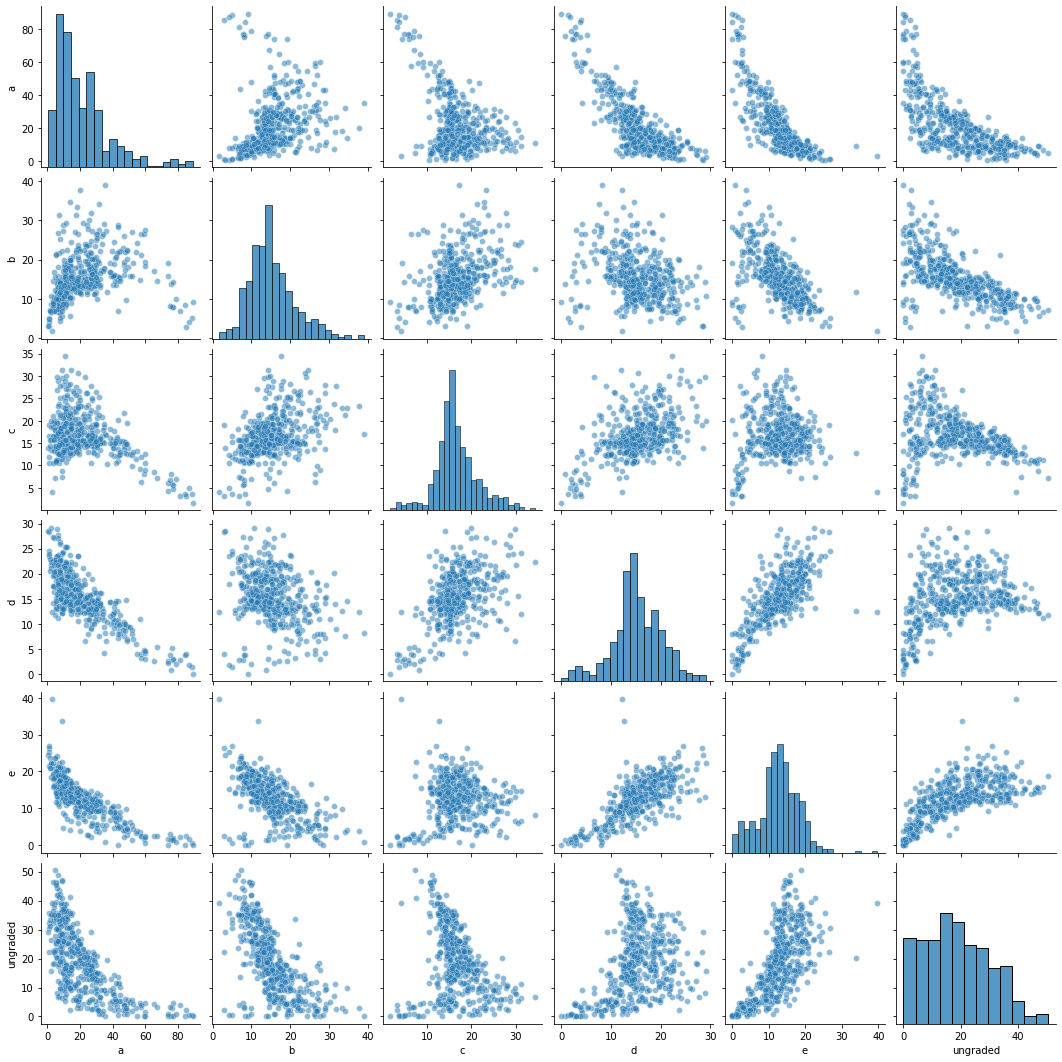

In [55]:
sns.pairplot(data=df_as[AS_NEW_COL], plot_kws={'alpha': 0.5})

From the graphs, it can be seen that there is an inverse relationship between distribution of ungraded, e and d to grade a and b. There is a positive relationship between grade a and b.

In [56]:
df_as

a     b     c     d     e  \
Series     Series_index Subject                                            
2015-11-01 0            Accounting          20.4  13.7  15.6  12.5  11.2   
           1            Afrikaans Language  42.4  15.8  15.9  12.5   8.0   
           2            Applied ICT         12.1  10.1  13.8  15.1  20.5   
           3            Arabic Language     75.9  13.8   8.2   0.7   1.4   
           4            Art and Design       8.9  12.7  17.4  18.5  20.7   
...                                          ...   ...   ...   ...   ...   
2020-11-01 32           Sociology           18.4  14.5  14.7  14.4  14.4   
           33           Spanish Language    48.0   9.8  14.7  14.8   9.8   
           34           Thinking Skills      9.5   8.7  12.9  13.0  18.7   
           35           Travel and Tourism  10.5  17.3  15.7  21.1  18.5   
           36           Urdu Language       79.0  10.0   7.0   2.0   1.0   

                                            ungraded  Series_month  
Series     Series_index Subject                                     
2015-11-01 0            Accounting              26.6            11  
           1            Afrikaans Language       5.4            11  
           2            Applied ICT             28.4            11  
           3            Arabic Language          0.0            11  
           4            Art and Design          21.8            11  
...                                              ...           ...  
2020-11-01 32           Sociology               23.6            11  
           33           Spanish Language         2.9            11  
           34           Thinking Skills         37.2            11  
           35           Travel and Tourism      16.9            11  
           36           Urdu Language            1.0            11  

[471 rows x 7 columns]

We can also look at subjects with abnormally high A rate.

In [57]:
locate_outlier(df_as.reset_index(), columns=['a'], zscore_threshold=2.5)

,Series,Series_index,Subject,a,b,c,d,e,ungraded,Series_month,Outlier_field
3,2015-11-01,3,Arabic Language,75.9,13.8,8.2,0.7,1.4,0.0,11,a
8,2015-11-01,8,Chinese Language,85.1,2.9,3.1,3.9,2.6,2.4,11,a
122,2018-06-01,23,Portuguese Language,73.9,19.1,4.4,2.6,0.0,0.0,6,a
137,2016-11-01,8,Chinese Language,88.7,5.0,3.6,1.4,0.7,0.6,11,a
177,2017-11-01,8,Chinese Language,76.5,8.0,5.9,5.2,1.6,2.8,11,a
213,2019-11-01,6,Chinese Language,77.2,7.9,5.7,2.8,1.9,4.5,11,a
243,2019-11-01,36,Urdu Language,65.0,17.1,8.5,2.6,2.5,4.3,11,a
276,2020-06-01,1,Arabic Language,84.4,8.3,3.6,3.7,0.0,0.0,6,a
288,2020-06-01,13,Further Mathematics,73.6,15.9,6.0,2.2,1.6,0.7,6,a
315,2018-11-01,6,Chinese Language,81.1,6.9,3.1,2.7,2.3,3.9,11,a


In [58]:
outlier_subjects = locate_outlier(df_as.reset_index(), columns=['a'], zscore_threshold=2.5)['Subject'].unique()
outlier_subjects

array(['Arabic Language', 'Chinese Language', 'Portuguese Language',
       'Urdu Language', 'Further Mathematics'], dtype=object)

In [59]:
# mask = df_as.reset_index()['Subject'].isin(outlier_subjects)
# subject = df_as.reset_index()['Subject'].where(mask, "Others")
# df_temp = df_as.reset_index()
# df_temp['Subject'] = subject
# df_temp['size'] = [4 if flag else 8 for flag in mask]
# plt.figure(figsize=(12, 12))
# palette ={"Arabic Language": "gold", 
#           "Others": "lightgrey",
#           "Chinese Language": "gold",
#           "Urdu Language": "gold",
#           "Further Mathematics": "red",
#           "Portuguese Language": "gold"}

# sns.stripplot(data=df_temp, x='Series', y='a', hue='Subject', palette=palette)

In [60]:
df_std_as = df_as.groupby('Series').std()
df_mean_as = df_as.groupby('Series').mean()

In [61]:
df_mean_as

,a,b,c,d,e,ungraded,Series_month
Series,,,,,,,
2015-06-01,15.962069,13.737931,16.393103,16.455172,13.710345,23.741379,6.0
2015-11-01,21.252500,16.242500,17.372500,14.602500,12.827500,17.702500,11.0
2016-06-01,16.590000,14.816667,16.316667,15.593333,13.740000,22.943333,6.0
2016-11-01,20.790000,15.207500,16.860000,16.252500,12.520000,18.370000,11.0
2017-06-01,16.776667,14.130000,16.336667,16.480000,13.473333,22.803333,6.0
2017-11-01,20.157895,15.552632,17.802632,15.631579,12.057895,18.797368,11.0
2018-06-01,17.363333,13.840000,15.763333,15.956667,13.526667,23.550000,6.0
2018-11-01,20.034211,15.255263,16.671053,16.097368,13.100000,18.842105,11.0
2019-06-01,15.658065,13.609677,15.600000,15.648387,14.951613,24.532258,6.0


In [62]:
# df_as.index.get_level_values('Series')[0]

In [63]:
# from matplotlib import dates

In [64]:
# # ax = plot_trend(data=df_std_as, y='ungraded', date_index_name="Series", ax_format=format_ax, label='std')
# ax = plot_trend(data=df_std_as, y='ungraded', x=df_std_as.index.get_level_values('Series'), date_index=False)
# ax.set_title("Standard deviation of ungraded over time")

In [65]:
# ax = plot_trend(data=df_mean_as, y='ungraded', x=df_std_as.index.get_level_values('Series'), date_index=False)
# ax.set_title("Mean of ungraded over time")

## A Level Analysis

Similar to AS level, we will replace the cumulative sum values to individual values.

In [66]:
df_a

A*  A or above  B or above  \
Series     Series_index Subject                                                
2015-06-01 0            Accounting               8.4        24.3        43.0   
           1            Applied ICT              2.3        12.7        31.7   
           2            Art and Design           4.1        13.5        34.1   
           3            Biology                 14.2        32.0        50.0   
           4            Business Studies         4.6        12.3        24.7   
...                                              ...         ...         ...   
2021-03-01 5            Information Technology   3.8        11.0        19.5   
           6            Mathematics             13.5        33.3        54.6   
           7            Physics                 15.5        27.7        40.7   
           8            Psychology               4.2        13.6        31.7   
           9            Sociology                3.3        17.4        33.1   

                                                C or above  D or above  \
Series     Series_index Subject                                          
2015-06-01 0            Accounting                    61.1        75.7   
           1            Applied ICT                   52.4        71.4   
           2            Art and Design                56.5        71.0   
           3            Biology                       67.5        79.9   
           4            Business Studies              44.8        63.8   
...                                                    ...         ...   
2021-03-01 5            Information Technology        39.4        59.3   
           6            Mathematics                   72.7        84.9   
           7            Physics                       56.7        71.3   
           8            Psychology                    50.3        66.4   
           9            Sociology                     52.9        71.9   

                                                E or above  AS A-E grades  \
Series     Series_index Subject                                             
2015-06-01 0            Accounting                    86.2            3.2   
           1            Applied ICT                   82.8            3.5   
           2            Art and Design                82.2            1.5   
           3            Biology                       88.9            2.3   
           4            Business Studies              78.8            4.4   
...                                                    ...            ...   
2021-03-01 5            Information Technology        79.2            2.2   
           6            Mathematics                   93.6            1.8   
           7            Physics                       85.1            3.5   
           8            Psychology                    83.1            4.7   
           9            Sociology                     87.6            0.0   

                                                ungraded  
Series     Series_index Subject                           
2015-06-01 0            Accounting                  10.6  
           1            Applied ICT                 13.7  
           2            Art and Design              16.3  
           3            Biology                      8.8  
           4            Business Studies            16.8  
...                                                  ...  
2021-03-01 5            Information Technology      18.6  
           6            Mathematics                  4.6  
           7            Physics                     11.4  
           8            Psychology                  12.2  
           9            Sociology                   12.4  

[412 rows x 8 columns]

In [67]:
df_a.columns

Index(['A*', 'A or above', 'B or above', 'C or above', 'D or above',
       'E or above', 'AS A-E grades', 'ungraded'],
      dtype='object')

In [68]:
A_COL = df_a.columns
A_NEW_COL = ['A*', 'A', 'B', 'C', 'D', 'E', 'AS A-E grades', 'ungraded']

df_a_cumul = a_level_stat.copy()

for i in range(len(A_COL)):
  if 1 <= i <= 5:
    df_a[A_COL[i]] = df_a_cumul[A_COL[i]] - df_a_cumul[A_COL[i - 1]]
  
  else:
    continue

df_a.columns = A_NEW_COL

In [69]:
df_a

A*     A     B     C     D  \
Series     Series_index Subject                                                
2015-06-01 0            Accounting               8.4  15.9  18.7  18.1  14.6   
           1            Applied ICT              2.3  10.4  19.0  20.7  19.0   
           2            Art and Design           4.1   9.4  20.6  22.4  14.5   
           3            Biology                 14.2  17.8  18.0  17.5  12.4   
           4            Business Studies         4.6   7.7  12.4  20.1  19.0   
...                                              ...   ...   ...   ...   ...   
2021-03-01 5            Information Technology   3.8   7.2   8.5  19.9  19.9   
           6            Mathematics             13.5  19.8  21.3  18.1  12.2   
           7            Physics                 15.5  12.2  13.0  16.0  14.6   
           8            Psychology               4.2   9.4  18.1  18.6  16.1   
           9            Sociology                3.3  14.1  15.7  19.8  19.0   

                                                   E  AS A-E grades  ungraded  
Series     Series_index Subject                                                
2015-06-01 0            Accounting              10.5            3.2      10.6  
           1            Applied ICT             11.4            3.5      13.7  
           2            Art and Design          11.2            1.5      16.3  
           3            Biology                  9.0            2.3       8.8  
           4            Business Studies        15.0            4.4      16.8  
...                                              ...            ...       ...  
2021-03-01 5            Information Technology  19.9            2.2      18.6  
           6            Mathematics              8.7            1.8       4.6  
           7            Physics                 13.8            3.5      11.4  
           8            Psychology              16.7            4.7      12.2  
           9            Sociology               15.7            0.0      12.4  

[412 rows x 8 columns]

In [70]:
# Resulting dataset
df_a_by_series = df_a.groupby('Series').describe()
df_a_by_series

A*                                                            A  \
           count       mean        std  min    25%    50%     75%   max count   
Series                                                                          
2015-06-01  25.0   6.676000   5.357104  0.0  2.300   4.60  10.000  17.0  25.0   
2015-11-01  32.0   6.709375   8.457993  0.0  2.100   2.85   9.500  40.7  32.0   
2016-06-01  26.0   6.246154   5.222508  0.0  1.825   4.70  10.225  16.3  26.0   
2016-11-01  35.0   6.588571   9.878014  0.0  1.300   3.00   8.600  54.0  35.0   
2017-06-01  27.0   6.388889   5.150678  0.0  2.300   5.70   9.850  17.9  27.0   
2017-11-01  62.0   5.969355   8.272304  0.0  1.900   3.00   7.625  43.0  62.0   
2018-06-01  27.0   6.774074   5.652746  0.0  1.700   5.50  11.100  19.5  27.0   
2018-11-01  35.0   7.071429   9.997605  0.0  2.100   3.60   6.500  50.0  35.0   
2019-06-01  27.0   7.318519   6.148048  0.0  2.350   5.60  11.250  22.4  27.0   
2019-11-01  34.0   7.194118   9.909590  0.0  1.775   3.60   7.975  44.0  34.0   
2020-03-01   9.0   7.100000   4.159627  0.0  4.300   8.50  10.600  11.3   9.0   
2020-06-01  29.0  16.610345   9.919114  0.6  8.200  18.10  25.800  37.3  29.0   
2021-03-01  10.0  10.770000   5.619816  3.3  5.125  11.85  15.650  17.6  10.0   
2021-06-01  34.0  17.255882  12.748742  0.7  6.875  14.25  27.900  42.1  34.0   

                       ... AS A-E grades       ungraded                       \
                 mean  ...           75%   max    count       mean       std   
Series                 ...                                                     
2015-06-01  13.508000  ...         4.500  11.1     25.0  11.980000  7.746236   
2015-11-01  11.446875  ...         7.100  15.1     32.0  13.987500  9.620132   
2016-06-01  12.488462  ...         4.300  16.9     26.0  12.530769  7.544257   
2016-11-01  11.737143  ...         6.950  12.2     35.0  12.408571  9.446237   
2017-06-01  14.200000  ...         4.050  14.5     27.0  11.633333  7.793094   
2017-11-01  11.408065  ...         7.200  13.7     58.0  13.232759  9.297281   
2018-06-01  14.225926  ...         4.000  16.6     27.0  11.533333  8.014170   
2018-11-01  11.028571  ...         6.850  17.2     35.0  12.877143  9.806603   
2019-06-01  15.285185  ...         4.500  14.4     27.0  10.755556  7.691820   
2019-11-01  11.450000  ...         6.600  19.6     34.0  13.341176  9.695582   
2020-03-01  11.800000  ...         2.300   3.2      9.0  11.877778  4.531495   
2020-06-01  24.031034  ...         0.000   0.0     29.0   3.248276  4.999759   
2021-03-01  13.580000  ...         3.175   4.7     10.0  11.020000  4.370050   
2021-06-01  18.738235  ...         2.000  10.4     34.0   4.617647  4.011156   

                                              
            min     25%    50%     75%   max  
Series                                        
2015-06-01  0.0   7.500  10.60  15.500  32.3  
2015-11-01  0.0   6.025  13.95  19.850  36.0  
2016-06-01  0.0   7.450  12.15  15.775  29.6  
2016-11-01  0.0   3.350  12.50  18.400  36.3  
2017-06-01  0.0   6.700  11.40  14.050  27.5  
2017-11-01  0.0   7.225  12.55  17.500  38.0  
2018-06-01  0.0   5.650  11.20  17.100  27.1  
2018-11-01  0.0   4.450  12.90  19.200  41.7  
2019-06-01  0.0   5.150  10.10  16.000  24.8  
2019-11-01  0.0   6.175  11.55  19.825  39.1  
2020-03-01  8.2   8.700  11.10  12.800  22.7  
2020-06-01  0.0   0.400   1.00   2.600  17.6  
2021-03-01  3.5  10.225  11.75  12.350  18.6  
2021-06-01  0.0   1.450   3.20   7.600  14.4  

[14 rows x 64 columns]

### Data Analysis

We will plot the trend graph similar to AS level.

In [71]:
@widget.interact(grade=A_NEW_COL)
def plot_as_trend_by_grade(grade):
  target_col = df_a_by_series.columns.values[df_a_by_series.columns.get_loc(grade)]
  plot_each_col(df_a_by_series, x=df_a_by_series.index.get_level_values('Series'),
              col_list=target_col, n_col=3, plot_type='trend', date_index=False, 
              title=f"Trend of '{grade}' grade statistics in A level over time", title_suffix="Trend of ", marker='o')

interactive(children=(Dropdown(description='grade', options=('A*', 'A', 'B', 'C', 'D', 'E', 'AS A-E grades', '…

In [72]:
@widget.interact(info=DESCRIBE_COL)
def plot_a_trend_by_info(info):
  target_col = df_a_by_series.columns.values[df_a_by_series.swaplevel(axis=1).columns.get_loc(info)]
  plot_each_col(df_a_by_series, x=df_a_by_series.index.get_level_values('Series'),
              col_list=target_col, n_col=3, plot_type='trend', date_index=False, 
              title=f"Trend of '{info}' grade statistics in A level over time", title_suffix="Trend of ", marker='o')

interactive(children=(Dropdown(description='info', options=('count', 'mean', 'std', 'min', '25%', '50%', '75%'…

Again we see that there is huge change in the distribution starting year 2020 May/June series, which is the first examination administered during pandemic. 

In [73]:
df_a_by_subject = df_a.groupby('Subject').mean()

In [74]:
@widget.interact(grade=A_NEW_COL)
def plot_subject_grade_mean(grade):
  fg = sns.catplot(data=df_a.reset_index(), y=grade, x='Subject', aspect=1.5, height=8, kind='bar', order=df_a_by_subject.sort_values(grade).reset_index()['Subject'])
  fg.axes[0, 0].set_xticklabels(fg.axes[0, 0].get_xticklabels(), rotation=90)
  fg.set_titles(f"Mean percentage of {grade} grade by subject")

interactive(children=(Dropdown(description='grade', options=('A*', 'A', 'B', 'C', 'D', 'E', 'AS A-E grades', '…

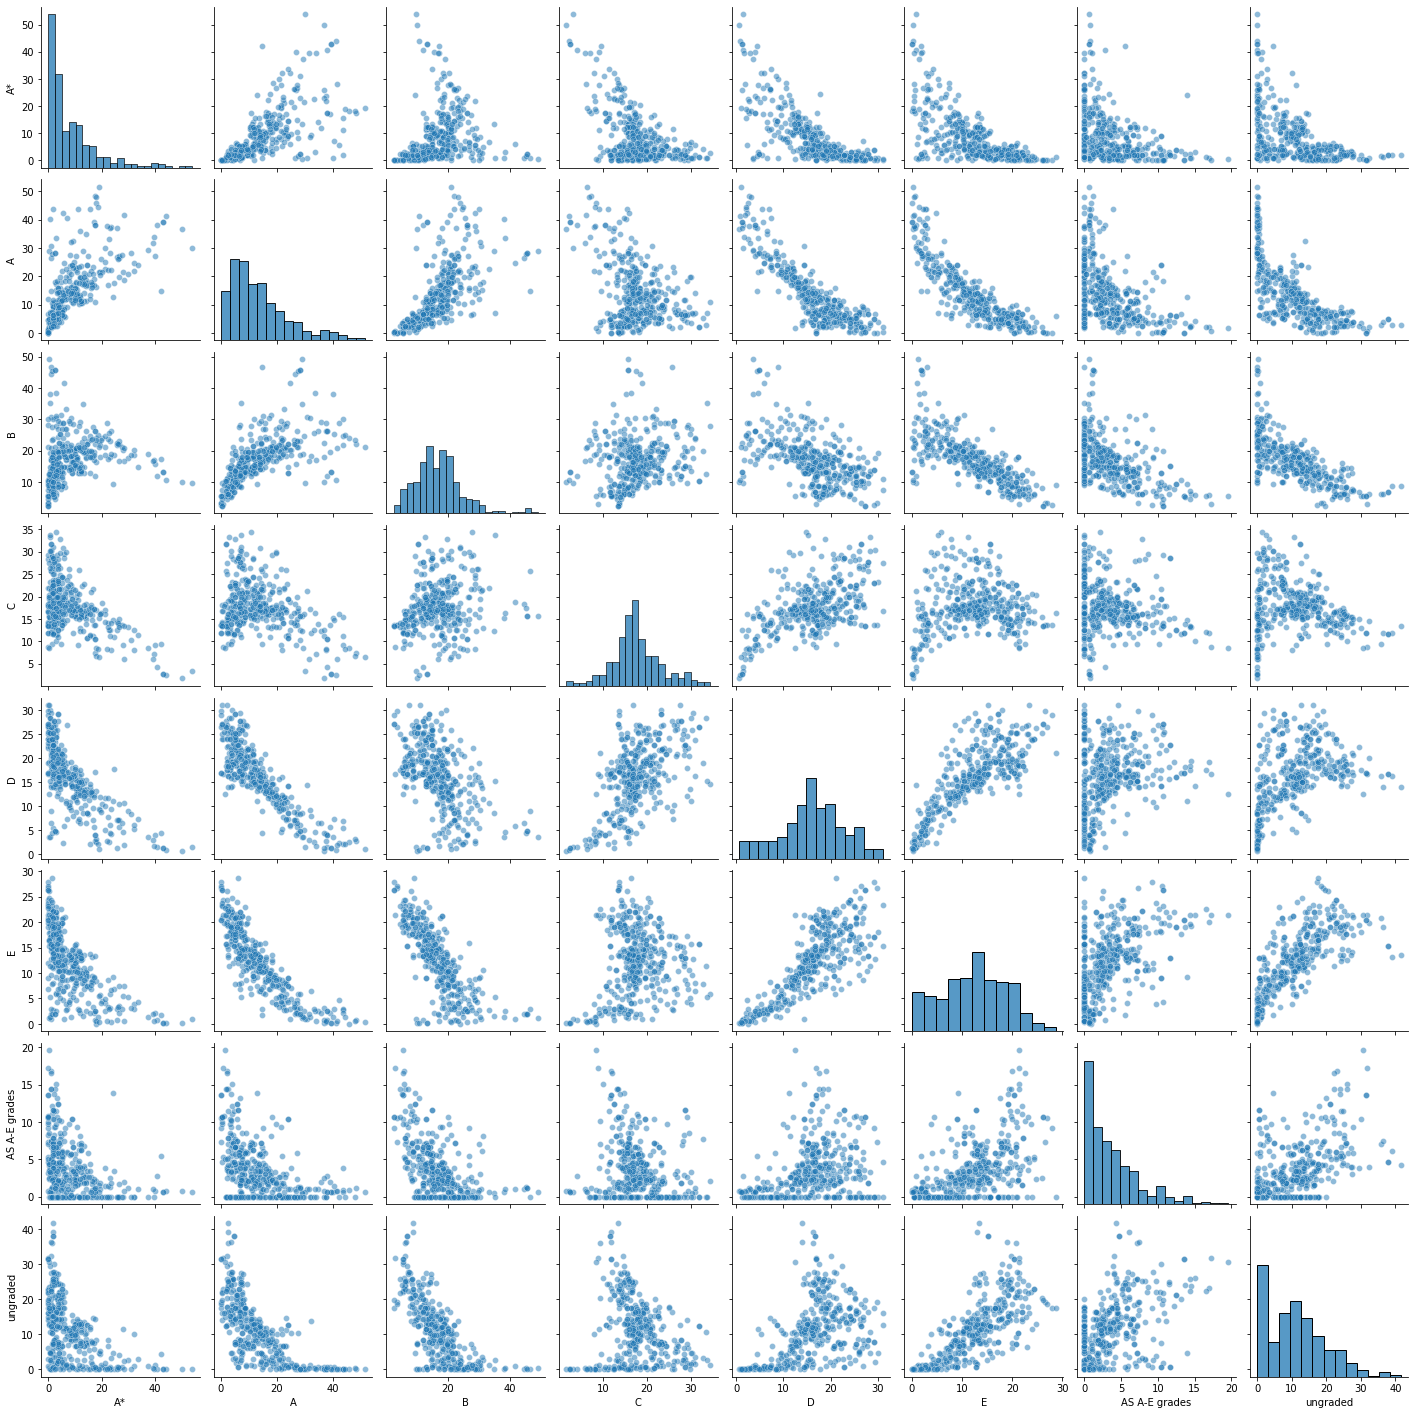

In [75]:
sns.pairplot(data=df_a.reset_index()[A_NEW_COL], plot_kws={'alpha': 0.5})

Similar to AS results, there are a few moderate correlations we can see from the scatter plots. For example, there is negative correlation between grade D and A (meaning that for a given subject, the lower the percentage of people getting A, the higher the percentage of people getting D).